In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training Transformer

In [76]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split, get_sample_weights, get_eval_set
from src.preprocessing import preprocess_data
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_auc_score
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
import transformers
from peft import get_peft_model, LoraConfig, TaskType
import re
from bert_score import BERTScorer
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.tokenize import word_tokenize
from src.path_reader import BASE_PATH_TRAIN


from transformers import BitsAndBytesConfig

tqdm.pandas()

In [77]:
os.listdir(BASE_PATH_TRAIN)

['ArgentinaBelgium72.csv',
 'ArgentinaGermanyFinal77.csv',
 'AustraliaNetherlands29.csv',
 'AustraliaSpain34.csv',
 'BelgiumSouthKorea59.csv',
 'CameroonBrazil36.csv',
 'FranceGermany70.csv',
 'FranceNigeria66.csv',
 'GermanyAlgeria67.csv',
 'GermanyBrazil74.csv',
 'GermanyUSA57.csv',
 'HondurasSwitzerland54.csv',
 'MexicoCroatia37.csv',
 'NetherlandsChile35.csv',
 'PortugalGhana58.csv',
 'USASlovenia2010.csv']

In [105]:
thresholds = [1,]

for file in os.listdir(BASE_PATH_TRAIN):
    df = pd.read_csv(os.path.join(BASE_PATH_TRAIN, file))

    print(f"\n\n File = {file}")

    df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
        'Tweet': len,
        "EventType": np.mean
    })

    

    for t in thresholds:
        z = df['Tweet']/df['Tweet'].median()
        y_pred = (z > t).astype(int)

        print(t, accuracy_score(df['EventType'], y_pred),)
        print(confusion_matrix(df['EventType'], y_pred))
            

    



 File = ArgentinaBelgium72.csv
1 0.4846153846153846
[[25 27]
 [40 38]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = ArgentinaGermanyFinal77.csv
1 0.5222222222222223
[[60 56]
 [30 34]]


 File = AustraliaNetherlands29.csv
1 0.7628865979381443
[[34  8]
 [15 40]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = AustraliaSpain34.csv
1 0.7307692307692307
[[41 11]
 [24 54]]


 File = BelgiumSouthKorea59.csv
1 0.7153846153846154
[[35  7]
 [30 58]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = CameroonBrazil36.csv
1 0.676923076923077
[[28  5]
 [37 60]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = FranceGermany70.csv
1 0.6230769230769231
[[36 20]
 [29 45]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = FranceNigeria66.csv
1 0.6461538461538462
[[40 21]
 [25 44]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = GermanyAlgeria67.csv
1 0.7411764705882353
[[68 27]
 [17 58]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = GermanyBrazil74.csv
1 0.4461538461538462
[[26 33]
 [39 32]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = GermanyUSA57.csv
1 0.7
[[50 24]
 [15 41]]


 File = HondurasSwitzerland54.csv
1 0.6615384615384615
[[37 16]
 [28 49]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = MexicoCroatia37.csv
1 0.6230769230769231
[[37 21]
 [28 44]]


 File = NetherlandsChile35.csv
1 0.6153846153846154
[[39 24]
 [26 41]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({




 File = PortugalGhana58.csv
1 0.7461538461538462
[[52 20]
 [13 45]]


 File = USASlovenia2010.csv
1 0.7923076923076923
[[47  9]
 [18 56]]


/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
/tmp/ipykernel_630570/3482080844.py:8: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({


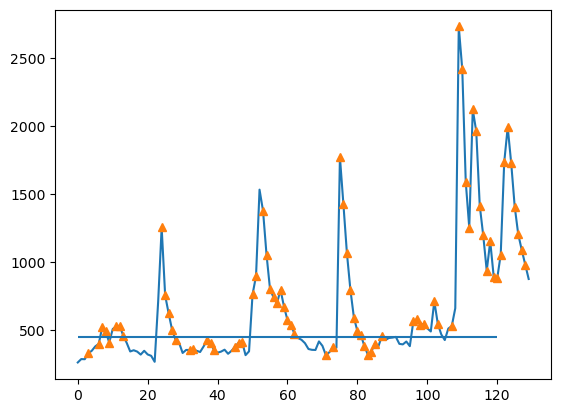

In [109]:
df['Tweet'].plot()
(df['Tweet'] [df['EventType'] == 1]).plot(linestyle = "", marker = '^')
plt.hlines(df['Tweet'].median(), 0 , 120)

In [96]:
accuracy_score(df['EventType'],df['Tweet']>500)

0.7538461538461538

In [79]:
z = (df['Tweet'] - df['Tweet'].mean())/df['Tweet'].std()

<Axes: >

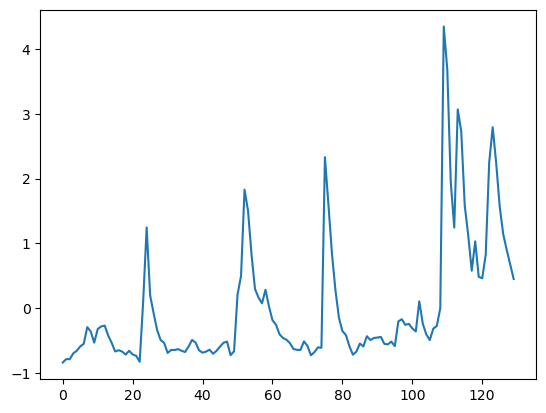

In [80]:
z.plot()

In [81]:
df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({
    'Tweet': len,
    "EventType": np.mean
})

/tmp/ipykernel_630570/2400856684.py:1: FutureWarning: The provided callable <function mean at 0x7f78f8305da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(['MatchID', "PeriodID"], as_index=False).agg({


In [82]:
df['avg_5_tweets'] = df['Tweet'].rolling(5).mean()

In [83]:
(df['avg_5_tweets']).corr(df['EventType'], method='spearman')

/users/eleves-a/2022/pedro.silva/Desktop/pay_attention_to_what_matters/.conda/lib/python3.11/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


nan

In [84]:
# y_pred = 
for t in thresholds:
    y_pred = (df['Tweet'] > t).astype(int)

    print(t, accuracy_score(df['EventType'], y_pred),)
    print(confusion_matrix(df['EventType'], y_pred))
        

        # confusion_matrix(df['EventType'], y_pred)

1.5 0.4307692307692308
[[56  0]
 [74  0]]
2 0.4307692307692308
[[56  0]
 [74  0]]
